# Introduction to Dask

Dask is a parallel computing library that scales the existing Python ecosystem. This tutorial will introduce Dask and parallel data analysis more generally.

Dask can scale down to your laptop laptop and up to a cluster. Here, we'll use an environment you setup on your laptop to analyze medium sized datasets in parallel locally.

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [4]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [5]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 773 µs, sys: 1.06 ms, total: 1.83 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of ane-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [2]:
from dask.delayed import delayed

In [6]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 702 µs, sys: 321 µs, total: 1.02 ms
Wall time: 804 µs


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [7]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 6.77 ms, sys: 3.02 ms, total: 9.78 ms
Wall time: 2.01 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [8]:
z

Delayed('add-fcaf4e35-6014-481f-a9da-0b8c276668b7')

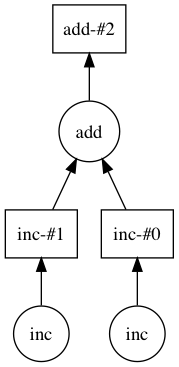

In [9]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [10]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 11.3 ms, sys: 3.34 ms, total: 14.7 ms
Wall time: 8.03 s


In [12]:
total

44

In [ ]:
%%time
# Your parallel code here...

In [ ]:
# %load solutions/01-delayed-loop.py
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delay`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```